# LOAD LIBRARIES

In [1]:
%load_ext line_profiler
%load_ext autoreload

% autoreload 0

import magni
from magni.cs.reconstruction.amp import run, config
from magni.cs.reconstruction.amp.util import theta_mm
import magni.utils.matrices as mat
from amp_magni_self import amp_magni_self

import os
import joblib
import numpy as np
from scipy.misc import imresize
import scipy.ndimage as scimg
import scipy.fftpack as spfft
import matplotlib.pyplot as plt
from skimage.measure import compare_psnr
from tqdm import tqdm_notebook

from wavelets_self import Haar 

np.random.seed(1234)
np.set_printoptions(precision=3)
%matplotlib inline

# NOTES
1. [DCT Notes](http://bugra.github.io/work/notes/2014-07-12/discre-fourier-cosine-transform-dft-dct-image-compression/)
2. [Magni Sample](http://magni.readthedocs.io/en/latest/magni.cs.reconstruction.amp._algorithm.html)
3. Magni Files : `/home/strider/anaconda3/lib/python3.5/site-packages/magni/cs/reconstruction`

# CLASSES FOR AMP

In [2]:
class DCT():
    def dct2(self, x):
        return spfft.dct(spfft.dct(x.T, norm='ortho', axis=0).T, norm='ortho', axis=0)

    def idct2(self, x):
        return spfft.idct(spfft.idct(x.T, norm='ortho', axis=0).T, norm='ortho', axis=0)
    
    """ Objective here is to see how k-sparse is the image? """
    def study_dct_k(self, url_img, nx=100, ny = 100, psnr_threshold = 25, show = False):
        img = scimg.imread(url_img, flatten=True, mode='L')
        img_resize = imresize(img, (nx,ny))/255.0
        alpha = dct2(img_resize)

        alpha_hist = np.sort(np.abs(alpha.ravel()))
        range_study = range(50,100,5)
        if show : f, axarr = plt.subplots(len(range_study), 1, figsize=(17,17))

        for i, perc_i in enumerate(range_study):
            alpha_10x_percentile_val = np.percentile(alpha_hist, perc_i)
            alpha_plt = alpha.copy()
            alpha_plt[(alpha_plt > -1*alpha_10x_percentile_val) & (alpha_plt < alpha_10x_percentile_val)] = 0
            k_sparse = len(np.nonzero(alpha_plt)[0])
            alpha_plt_idct2 = idct2(alpha_plt)
            if show : axarr[i].imshow(alpha_plt_idct2, cmap='gray')
            psnr = compare_psnr((img_resize).astype('float32'), alpha_plt_idct2.astype('float32'))
            if show : print (perc_i, 'th percentile:', alpha_10x_percentile_val, ' PSNR:', psnr, 'dB', ' ', k_sparse, '-sparse')

            if psnr >= psnr_threshold:
                k_sparse_res = k_sparse

        if show : print ('\nThreshold pSNR = ', psnr_threshold)
        if show : print ('N = ', nx*ny)
        if show : print ('k-sparse:', k_sparse_res)
        if show : print ('m = O(k*log(N)) ~ ', k_sparse_res * np.log(nx*ny))
        return k_sparse_res
    

class AMP():
    
    def __init__(self, dimension):
        self.dimension = dimension
        self.url_img = ''
        self.nx = 0
        self.ny = 0
        self.MR = 0.0
        self.transform_basis = ''
        self.matrix_type = ''
        self.matrix_size_max = 2000
        self.show = 0
        
        self.X_orig = []
        self.X = []
        self.A = []
        self.y = []
        self.xhat = []
        
        self.tolerance = 1e-6
        self.iterations = 300
        self.verbose_solver = 0
    
    def get_data(self):
        if self.dimension == 1:
            return self.get_data_1D()
        elif self.dimension == 2:
            return self.get_data_2D(self.url_img, nx = self.nx, ny = self.ny
                                    , transform_basis = self.transform_basis
                                    , show = self.show)
    
    def get_data_1D(self):
        k, m, N = 10, 200, 400
        A = 1 / np.sqrt(m) * np.random.randn(m, N)
        X = np.zeros((N, 1))
        X[:k] = np.random.normal(scale=1, size=(k, 1))
        y = A.dot(X)
        print ('Variable Shapes:', y.shape, A.shape, X.shape)
        return y, A, X, m, N

    def helper_X_transform(self, X, transform_basis):
        if transform_basis == 'dct':
            X = DCT().dct2(X)
        elif transform_basis == 'haar':
            # alpha = pywt.dwt2(img_resize, 'haar')
            haar = Haar()
            X = haar.dwt2d(X * 255.0)
        
        return X
    
    def helper_measurement_A(self, m, N, matrix_type = 'random_normalized', matrix_size_max = 2000):
        """
        A as a matrix of iid variables drawn from Gaussian or bernoulli distributions is inherently inchoherent with 
            all other sparsifying basis
        """
        """ 
        Notes
         - unable to create random A matrices for images above 100 x 100
         - need to find an in memory option
        """
        
        # matrix_type = 'random_normalized'
        # matrix_type = 'random'
        # matrix_type = 'function'
        
        if matrix_type == 'random':
            # A = 1 / np.sqrt(400) * np.random.randn(m, N)
            A = np.random.randn(m, N)
            # A = np.random.choice([0,1], size=(k,N))
            A_size_mb = A.nbytes/1024.0/1024.0
            print ('Sensing Matrix : A (MB):', A_size_mb, ' A.shape:', A.shape)
            if A_size_mb < matrix_size_max:
                return A         
        
        elif matrix_type == 'random_normalized':
            file_name = 'data/A_random_normalized_m_' + str(m) + '_N_' + str(N) + '.gz'
            if not os.path.isfile(file_name):
                A = np.empty((m, N), dtype=np.float16)
                A_size_mb = A.nbytes/1024.0/1024.0
                print ('Sensing Matrix : A (MB):', A_size_mb, ' A.shape:', A.shape)

                if A_size_mb < matrix_size_max:
                    with tqdm_notebook(total = len(range(m)), desc = 'Randomizer') as pbar:
                        for i in range(m):
                            pbar.update(1)
                            A[i] = np.random.randn(1,N)[0]
                    with tqdm_notebook(total = len(range(A.shape[1])), desc = 'Normalizer') as pbar2:
                        for j in range(A.shape[1]):
                            pbar2.update(1)
                            A[:,j] = A[:,j]/np.sqrt(np.sum(np.abs(A[:,j]**2)))
                with open(file_name, 'wb') as handler:
                    joblib.dump(A, handler, compress=True)
            else:
                with open(file_name, 'rb') as handler:
                    A = np.array(joblib.load(handler))
                    A_size_mb = A.nbytes/1024.0/1024.0
                    print ('Sensing Matrix : A (MB):', A_size_mb, ' A.shape:', A.shape)
            
            return A
        
        elif matrix_type == 'function':
            pass
        
        return []
    
    def helper_getsize(self, x):
        if type(x) == np.ndarray:
            return str(round(x.nbytes/1024.9/1024.0,2)) + ' MB' 
    
    def get_data_2D(self, url_img, nx = 128, ny = 128, transform_basis = 'dct', MR = 0.6, show = False):
        
        ## Get the image, resize and transform
        img = scimg.imread(url_img, flatten=True, mode='L')
        img_resize = imresize(img, (nx,ny)) #/255.0 
        self.X_orig = img_resize
        print ('Img shape:', img.shape, ' Resized:', img_resize.shape)
        X = self.helper_X_transform(img_resize, transform_basis)
        print ('Resized Image (size) : ', self.helper_getsize(img_resize)
                       , ' Sparse Version : ', self.helper_getsize(X))
        
        if show : 
            f1, axarr1 = plt.subplots(1,2, figsize=(6,6))
            axarr1[0].imshow(img, cmap=plt.cm.gray)
            axarr1[1].imshow(img_resize, cmap=plt.cm.gray)

            f2, axarr2 = plt.subplots(1,2, figsize=(6,6))
            axarr2[0].imshow(X,cmap=plt.cm.Paired)
            axarr2[1].hist(np.log10(np.abs(X.ravel())), bins=100, color='#348ABD', alpha=.3, histtype='stepfilled')

        
        N = X.shape[1] * X.shape[0]
        m = int(N * self.MR)
        print ('Measurement rate:', self.MR, ' No. of measurements:', m, '/', N)
        A = self.helper_measurement_A(m,N, matrix_type = self.matrix_type)
        
        
        if len(A):
            if X.shape[1] != 1:
                X = X.reshape((N,1))
            #if np.amax(X) > 3:
            #    X = X/255
            #    print ('Max values of X:',np.amax(X))

            # measurement_style = 'random'
            measurement_style = 'linear'
            if measurement_style == 'random':
                rand_idxs = np.random.choice([0,1], size = m)
                y = X[rand_idxs]
            else:
                y = A.dot(X)

            print ('Variable Shapes:', y.shape, A.shape, X.shape)
            self.y = y
            self.A = A
            self.X = X
            
            return y, A, X, img_resize, m, N
        else:
            print ('MemoryError: For variable A')
            return [], [], [], 0, 0

    def get_data_2D_v2(self, url_img, show=False):
        # https://stats.stackexchange.com/questions/62416/image-reconstruction-using-compressed-sensing
        nx, ny = 100, 100
        N = nx*ny
        MR = 0.5
        k = int(N*MR)
        k = 4900

        img = scimg.imread(url_img, flatten=True, mode='L')
        img_resize = imresize(img, (nx,ny))/255

        Atemp = np.zeros((1, N))
        idxs = np.random.permutation(np.arange(1, N))
        rand_idxs = sorted(idxs[1:k+1])

        A = np.zeros((k, N))
        for i, idx in enumerate(rand_idxs):
            Atemp[0,idx] = 1
            A[i, :] = spfft.dct(Atemp)
            Atemp[0, idx] = 0

        alpha = img_resize.reshape(N,1)
        y = alpha[rand_idxs]

        if show:
            f, axarr = plt.subplots(1,3)
            axarr[0].imshow(img, cmap = plt.cm.gray)
            axarr[1].imshow(img_resize, cmap = plt.cm.gray)
            axarr[2].imshow(y.reshape((70,70)), cmap = plt.cm.gray)

        print ('Variable Shapes:', y.shape, A.shape, alpha.shape)
        return y, A, alpha
    
    def amp_solver(self, y, A, X, X_orig, m, N):
        config['threshold_parameters'] = {'threshold_level_update_method': 'residual',
                                    'theta': theta_mm(float(m) / N)   #regularization param for thresholding func
                                  , 'tau_hat_sq': 1.0
                                 }
        config['report_history'] = False
        config['tolerance'] = self.tolerance
        config['iterations'] = self.iterations
        
        if config['report_history'] == True:
            xhat, history = run(y, A)
        else:
            xhat = run(y, A)
        self.xhat = xhat
        
        xhat_plt = self.amp_solver_results(y, A, X, X_orig, m, N, xhat)
        
        return xhat, xhat_plt
    
    def amp_solver_selfcoded(self, y, A, X, X_orig, m, N):
        % autoreload 0

        from amp_magni_self import amp_magni_self
        amp_magni_self_obj = amp_magni_self.AMP_Magni_Self(m, N, y, A, iterations = self.iterations, tolerance = self.tolerance
                            , verbose = self.verbose_solver)
        xhat = amp_magni_self_obj.run()
        self.xhat = xhat
        
        xhat_plt = self.amp_solver_results(y, A, X, X_orig, m, N, xhat)
        
        return xhat, xhat_plt
    
    def amp_solver_results(self, y, A, X, X_orig, m, N, xhat):
        residual = np.abs(X - xhat) > 1e-2
        residual = np.abs(X - xhat)
        residual_max = residual.max()

        print ('\n -------------------------------------------------- ')
        # print ('Max residual:',residual_max ,' SUM:', np.sum(residual))
        print ('pSNR (of iterative algo):', compare_psnr(X.astype('float32'), xhat.astype('float32'), dynamic_range=255))

        if self.dimension == 2:
            if self.transform_basis == 'dct':
                xhat_plt = DCT().idct2(xhat.reshape((self.nx, self.ny)))
            elif self.transform_basis == 'haar':
                haar = Haar()
                xhat_plt = Haar().idwt2d(xhat.reshape((self.nx, self.ny)))

            print ('pSNR (of transform basis):', compare_psnr(X_orig.reshape((self.nx,self.ny)).astype(np.float32)
                                                              , xhat_plt.astype(np.float32), dynamic_range=255))
            f, axarr = plt.subplots(1,2, figsize=(6,6))
            axarr[0].imshow(X_orig, cmap = plt.cm.gray)
            axarr[1].imshow(xhat_plt, cmap = plt.cm.gray)
        
        return xhat_plt


# IMAGE AND CLASS VARIABLE INPUTS

Img shape: (480, 500)  Resized: (128, 128)
Resized Image (size) :  0.02 MB  Sparse Version :  0.12 MB
Measurement rate: 0.6  No. of measurements: 9830 / 16384
Sensing Matrix : A (MB): 307.1875  A.shape: (9830, 16384)
Variable Shapes: (9830, 1) (9830, 16384) (16384, 1)


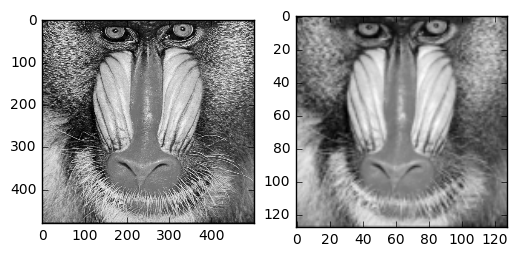

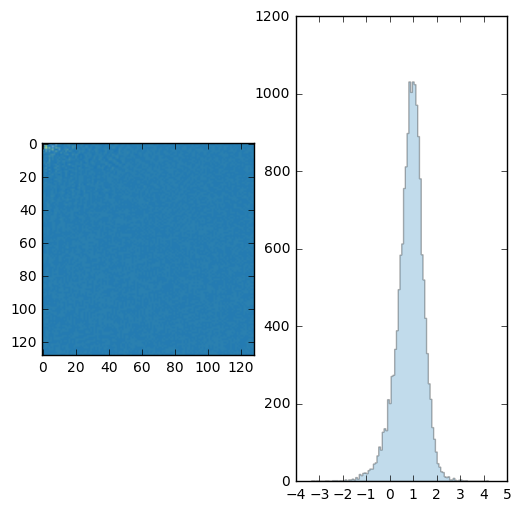

In [3]:
if __name__ == "__main__":
    """ CS STUDY """
    dimension = 2
    amp = AMP(dimension)
    
    if dimension == 1:
        y, A, X, X_orig, m, N = amp.get_data()
    else:
        amp.url_img = '../noniterative/data/original/SRCNN/Test/Set14/baboon.bmp'
        amp.nx = 128
        amp.ny = 128
        amp.MR = 0.6
        amp.transform_basis = 'dct' #'haar'
        amp.matrix_type = 'random_normalized'
        amp.show = 1
        y, A, X, X_orig, m, N = amp.get_data()

# USING MAGNI SOLVER

In [4]:
# % autoreload 0

# import magni
# from magni.cs.reconstruction.amp import run, config
# from magni.cs.reconstruction.amp.util import theta_mm
# import magni.utils.matrices as matrices

# amp.tolerance = 2.0
# amp.iterations = 100
# amp.verbose_solver = 0
# xhat, xhat_plt = amp.amp_solver(y, A, X, X_orig, m, N)

# USING SELF WRITTEN MAGNI SOLVER


Iterations: 80
MSE Tolerance: 2.0


<IPython.core.display.Javascript object>


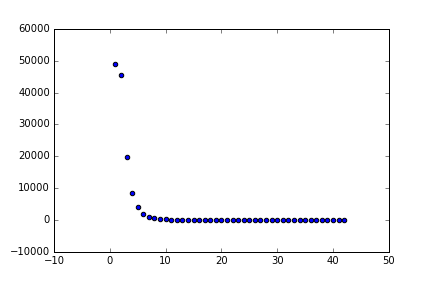

 --------------------------------------------------> Iter: 0 / 80


KeyboardInterrupt: 

<IPython.core.display.Javascript object>


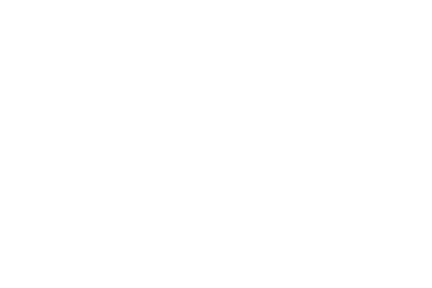

In [5]:
# % autoreload 1
# amp = amp.Magni_AMP(m, N, y, A, iterations = 100, tolerance = 5.0)
# xhat = amp.run()

%matplotlib notebook
amp.tolerance = 2.0
amp.iterations = 80
amp.verbose_solver = 0
xhat, xhat_plt = amp.amp_solver_selfcoded(y, A, X, X_orig, m, N)

# EXPERIMENTATION

<IPython.core.display.Javascript object>


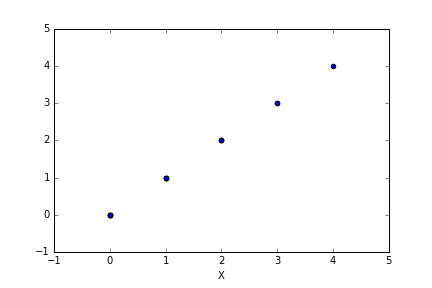

ax: Axes(0.125,0.125;0.775x0.775)
[0] [0]
[0, 1] [0, 1]
[0, 1, 2] [0, 1, 2]
[0, 1, 2, 3] [0, 1, 2, 3]
[0, 1, 2, 3, 4] [0, 1, 2, 3, 4]


<IPython.core.display.Javascript object>


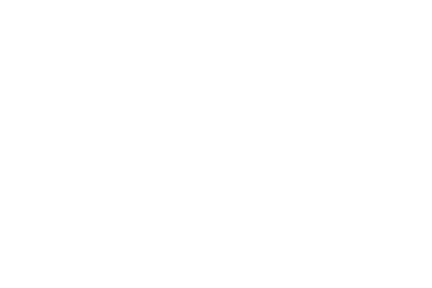

In [6]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
import time

def pltsin(ax, x, y):
    # x = np.linspace(0,1,100)
    ax.scatter(x, y)
    fig.canvas.draw()

fig,ax = plt.subplots(1,1, squeeze=True)
print ('ax:', ax)
ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_xlim(0,5)
# ax.set_ylim(0,5)
x = []
y = []
for f in range(5):
    x.append(f)
    y.append(f)
    pltsin(ax, x, y)
    print (x,y)
    time.sleep(1)

<IPython.core.display.Javascript object>


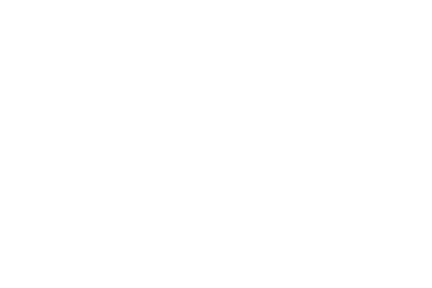

<Container object of 3 artists>

<IPython.core.display.Javascript object>


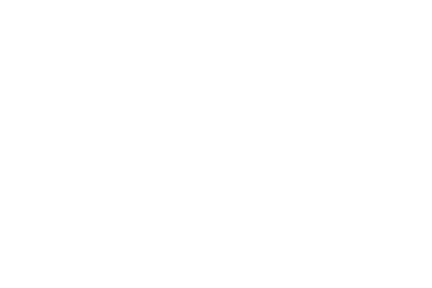

In [7]:
plt.bar([1,2,3], [10,20, 2])